<a href="https://www.kaggle.com/code/rudra01/audio-classifiers-final?scriptVersionId=116668136" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import os 
import math 
import warnings 
import random

import matplotlib.pyplot as plt
import numpy as np


import librosa 
import librosa.display
import IPython.display as ipd
import scipy.io.wavfile as wavf

import tensorflow as tf 
import tensorflow_io as tfio

import seaborn as sns
import pickle

## Setup 

In [3]:
base_path = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing'
cap_dir = os.path.join(base_path, 'Parsed_Capuchinbird_Clips')
non_cap_dir = os.path.join(base_path, 'Parsed_Not_Capuchinbird_Clips')
aug_dir = '/kaggle/input/parsed-augmented-44kclips'
add_ncap_dir = '/kaggle/input/neg-augmented44k-clips'
add_cap_dir = '/kaggle/input/mixed-augmented44k-clips'
add_test_dir = '/kaggle/input/testing-augmented44k-clps'


| Dirname | Info | Usability | Label |
| --- | --- | --- | --- |
| cap_dir | for original parsed_calls | AUG | 1 |
| non_cap_dir | for origignal non_parsed_calls | ALL | 0 |
| aug_dir | for augmented parsed_calls | AUG | 1 |
| add_cap_dir | for mixed parsed_calls | AUG | 1 |
| add_ncap_dir | for neg_pitch non_parsed_calls | AUG | 0 |
| add_test_dir | for extra mixed test files | ALL | 1 |

In [4]:
cap_file = os.path.join(cap_dir, 'XC114132-6.wav')
ncap_file = os.path.join(non_cap_dir, 'afternoon-birds-song-in-forest-10.wav')

## Helper functions 

In [5]:
Frame_size = 256
Hop_size = 129

def get_file_path(name, label):
    if label == 1:
        return os.path.join(cap_dir, name)
    else:
        return os.path.join(non_cap_dir, name)
    
    
def load_audio(filename):
    audio, sr = librosa.load(filename, mono=True, sr= 22050, dtype='float64')
    # print(f"the sample rate for following audio : {sr}")
    return audio, sr


def stft_audio(audio):
    sp = librosa.stft(audio, n_fft= Frame_size, hop_length = Hop_size)
    return sp 


def lin_spec_conversion(stft):
    # complex number to real number 
    stft = np.abs(stft)**2
    return stft

def log_spec_conversion(stft):
    stft = np.abs(stft)**2
    stft_log = librosa.power_to_db(stft)
    return stft_log

def plot_spectrogram(stft, sr, hop_length, y_axis = 'linear'):
    plt.figure(figsize=(6, 4))
    librosa.display.specshow(stft, 
                             sr=sr, 
                             hop_length=hop_length, 
                             x_axis="time", 
                             y_axis=y_axis)
    plt.colorbar(format="%+2.f")
#     plt.ylim([0, 15000])
#     plt.yticks(np.arange(0, 15000, 1500))

In [6]:
def aud_to_spec (filename):
    Frame_size = 512
    Hop_size = 257
    x, sr = librosa.load(filename, mono=True, sr= 22050, dtype=None)
    stft = stft_audio(x) 
    spec = lin_spec_conversion(stft)
    Ylog_spec = librosa.power_to_db(spec)

    return Ylog_spec, sr


def wav_to_spec (x, sr):
    # Frame_size = 256
    # Hop_size = 129
    stft = stft_audio(x) 
    spec = lin_spec_conversion(stft)
    Ylog_spec = librosa.power_to_db(spec, ref=np.max)
    # Ylog_spec = librosa.amplitude_to_db(spec, ref=np.max)
    # return spec, sr
    return Ylog_spec, sr

## Exploratory Data Analysis 

In [ ]:
wav, rate = librosa.load(cap_file, mono=False, dtype=None)
print("Sample capuchin_clip")
print("Sampling rate = ",  2*rate)
print("Shape of wave = ", wav.shape)

librosa.display.waveshow(wav, sr = 2*rate)
ipd.Audio(wav, rate = rate)

In [ ]:
waveL, rateL = aud_to_spec(cap_file)
plot_spectrogram(waveL, rateL, Hop_size)

In [ ]:
nwav, nrate = librosa.load(ncap_file, mono=False, dtype=None)

print("Sample non_capuchin_clip")
print("Sampling rate = ",  2*nrate)
print("shape of wave = ", nwav.shape)
librosa.display.waveshow(nwav, sr = nrate)
ipd.Audio(nwav, rate = nrate)

In [ ]:
nwaveL, nrateL = aud_to_spec(ncap_file)
plot_spectrogram(nwaveL, nrateL, Hop_size)

## Data Pre-processing

In [206]:
def add1 (a, b):
    return a + b 

def sub1 (a,b):
    return a - b 

In [224]:
def specFormation(filename, dirr, val):
    file_path = os.path.join(dirr, filename)
    wave , rate = load_audio(file_path)
#     print(len(wave), rate)
    wave = wave[:22050]
#     tf.convert_to_tensor():
        
    if len(wave) < 22050:
      zeropad = np.zeros(shape=(1, 22050))
      zeropad[:len(wave)] += wave
#     print(len(wave))
    stft = stft_audio(wave)
    stft_log = log_spec_conversion(stft)
    stft_lin = lin_spec_conversion(stft)
#     plot_spectrogram(stft_lin, rate, Hop_size)
    return stft_log if val == 'log' else stft_lin


def add_dim (spec):
    newsp = spec[:, :, np.newaxis]
#     print(newsp.shape)
    return newsp


def onelistmaker(n):
    listofzeros = [1] * n
    return listofzeros

def zerolistmaker(n):
    listofzeros = [0] * n
    return listofzeros


def obt_spec_fromList (dlist, dirr, val):
#     cnt = True if val == 'lin' else False
    dlist = list(map(lambda x: specFormation(x, dirr, val), dlist))
    dlist = list(map(add_dim , dlist))
    return dlist

    
def obt_ds_fromList (dlist, llist):
    dataset = tf.data.Dataset.from_tensor_slices(dlist)
    labels  = tf.data.Dataset.from_tensor_slices(llist)
    data = tf.data.Dataset.zip((dataset, labels))
    return data

In [8]:
cap_files = os.listdir(cap_dir)
ncap_files = os.listdir(non_cap_dir)
aug_files = os.listdir(aug_dir)
add_cap_files = os.listdir(add_cap_dir)
add_ncap_files = os.listdir(add_ncap_dir)
add_test_files = os.listdir(add_test_dir)

In [9]:
posl1 = [*cap_files]
posl2 = [*aug_files]
posl3 = [*add_cap_files]

negl1 = [*ncap_files]
negl2 = add_ncap_files[:75]
# negl2 = [*add_ncap_files]

testl1 = [*add_test_files]
testl2 = add_ncap_files[-15:]

print(len(posl1), len(posl2), len(posl3))
print(len(negl1), len(negl2))
print(len(testl1), len(testl2))

217 360 61
593 75
48 15


In [10]:
posl1 = obt_spec_fromList(posl1, cap_dir, val = 'lin')
posl2 = obt_spec_fromList(posl2, aug_dir, val = 'lin')
posl3 = obt_spec_fromList(posl3, add_cap_dir, val = 'lin')

negl1 = obt_spec_fromList(negl1, non_cap_dir, val = 'lin')
negl2 = obt_spec_fromList(negl2, add_ncap_dir, val = 'lin')

testl1 = obt_spec_fromList(testl1, add_test_dir, val = 'lin')
testl2 = obt_spec_fromList(testl2, add_ncap_dir, val = 'lin')

# print(value)
print(len(posl1), len(posl2), len(posl3))
print(len(negl1), len(negl2))
print(len(testl1), len(testl2))

217 360 61
593 75
48 15


## Importing Keras and sklearn Libraries

In [11]:
seed = 777

In [12]:
# to check balance after shuffling in dataset
def check_balance(data, sz):
    temp = []
    for i, (tensor, label) in enumerate(data.take(sz)):
        temp.append(label.numpy())
    
    
    temp = np.array(temp)
    count = np.count_nonzero(temp == 1.0)
    print(count*100/sz)

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score, fbeta_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import PrecisionRecallDisplay
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Model 1 (LISP) [linear amp spec without data augmnt]

### data_pipeline 1

In [14]:
neglist1 = [*negl1]
poslist1 = [*posl1]

ones  = onelistmaker(len(poslist1))
zers  = zerolistmaker(len(neglist1))

len(ones) , len(zers) , (len(ones) + len(zers))

(217, 593, 810)

In [15]:
t_ones = onelistmaker(len(testl1))
t_zers = zerolistmaker(len(testl2))
test_d1 = obt_ds_fromList(testl1, t_ones) 
test_d2 = obt_ds_fromList(testl2, t_zers) 

2023-01-10 18:15:57.265539: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
type(test_d2)

tensorflow.python.data.ops.dataset_ops.ZipDataset

In [17]:
pos1  = obt_ds_fromList(poslist1, ones)
neg1  = obt_ds_fromList(neglist1, zers)

In [18]:
print(pos1.element_spec, len(pos1))
print(neg1.element_spec, len(neg1))

(TensorSpec(shape=(129, 171, 1), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None)) 217
(TensorSpec(shape=(129, 171, 1), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None)) 593


In [19]:
data_m1 = neg1.concatenate(pos1)
tdata_m1 = test_d1.concatenate(test_d2)

In [23]:
data_m1 = data_m1.shuffle(buffer_size = 610, seed=seed, reshuffle_each_iteration=False)
print( check_balance(data_m1, 150) , len(data_m1) )

tdata_m1 = tdata_m1.shuffle(buffer_size = 45, seed=seed, reshuffle_each_iteration=False)
print( check_balance(tdata_m1, 50) , len(tdata_m1) )

28.666666666666668
None 810
80.0
None 63


In [24]:
data_m1 = data_m1.cache()
data_m1 = data_m1.shuffle(buffer_size=610, seed = seed, reshuffle_each_iteration=False)
data_m1 = data_m1.batch(16)
data_m1 = data_m1.prefetch(8)
len(data_m1)

51

### train/test split

In [25]:
# 31 - 9 - 11

train_m1 = data_m1.take(31)
t_data_m1 = data_m1.skip(31).take(20)
tst_m1 = t_data_m1.take(9)
validate_m1 = t_data_m1.skip(9).take(11)

print(len(train_m1), len(tst_m1), len(validate_m1) )

31 9 11


In [26]:
test_labels = np.concatenate([y for x, y in tst_m1], axis=0)
test_spec   = np.concatenate([x for x, y in tst_m1], axis=0)

In [27]:
test_extra = obt_ds_fromList(test_spec, test_labels)

In [28]:
len(test_extra), len(tdata_m1)


(144, 63)

In [29]:
test_m1 = tdata_m1.concatenate(test_extra)

In [30]:
test_m1 = test_m1.batch(16)
test_m1 = test_m1.prefetch(8)
len(test_m1)

13

### model 1 training

In [80]:
model1 = Sequential()
# model.add(Conv2D(32, (3,3), activation='relu', input_shape=(124, 129, 1)))
model1.add(layers.Input(shape= (129, 171, 1) ))

# model1.add(Conv2D(32, (4,4), activation='relu'))


model1.add(Conv2D(64, (4,4), activation='relu'))
model1.add(layers.AveragePooling2D(2,2))
# model.add(layers.Dropout(0.3))

model1.add(Conv2D(32, (4,4), activation='relu'))
model1.add(layers.MaxPooling2D(3,3))
# model.add(layers.Dropout(0.3))

model1.add(Flatten())

model1.add(Dense(64, activation='relu'))
model1.add(Dense(32, activation= 'relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 126, 168, 64)      1088      
_________________________________________________________________
average_pooling2d_7 (Average (None, 63, 84, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 60, 81, 32)        32800     
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 20, 27, 32)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 17280)             0         
_________________________________________________________________
dense_59 (Dense)             (None, 64)                1105984   
_________________________________________________________________
dense_60 (Dense)             (None, 32)              

In [81]:
model1.compile( optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='BinaryCrossentropy', metrics=['binary_accuracy', 'Recall', 'Precision'])

In [82]:
hist1 = model1.fit(train_m1, epochs=8, validation_data=validate_m1,
       callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, 
                                               patience=4,
                                               restore_best_weights=True
                                              ),
        steps_per_epoch = 31)

Epoch 1/8
31/31 [==============================] - 10s 278ms/step - loss: 0.4969 - binary_accuracy: 0.8690 - recall: 0.7405 - precision: 0.7578 - val_loss: 0.3120 - val_binary_accuracy: 0.9000 - val_recall: 0.6957 - val_precision: 0.9143
Epoch 2/8
31/31 [==============================] - 8s 246ms/step - loss: 0.2773 - binary_accuracy: 0.9032 - recall: 0.6794 - precision: 0.9368 - val_loss: 0.2770 - val_binary_accuracy: 0.8882 - val_recall: 0.6739 - val_precision: 0.8857
Epoch 3/8
31/31 [==============================] - 8s 245ms/step - loss: 0.2592 - binary_accuracy: 0.9032 - recall: 0.7023 - precision: 0.9109 - val_loss: 0.3101 - val_binary_accuracy: 0.9000 - val_recall: 0.7391 - val_precision: 0.8718
Epoch 4/8
31/31 [==============================] - 8s 262ms/step - loss: 0.1702 - binary_accuracy: 0.9294 - recall: 0.7481 - precision: 0.9800 - val_loss: 0.2282 - val_binary_accuracy: 0.9118 - val_recall: 0.7391 - val_precision: 0.9189
Epoch 5/8
31/31 [==============================] - 

### plotting training performance

In [83]:
metrics1 = hist1.history

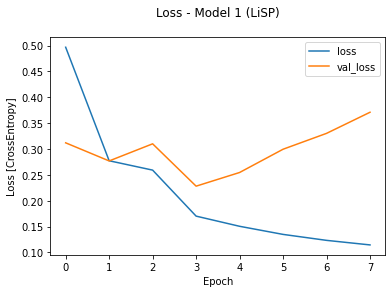

In [84]:
plt.title('Loss - Model 1 (LiSP)\n')


plt.plot(hist1.epoch, metrics1['loss'], metrics1['val_loss'])
plt.legend(['loss', 'val_loss'])
# plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.show()

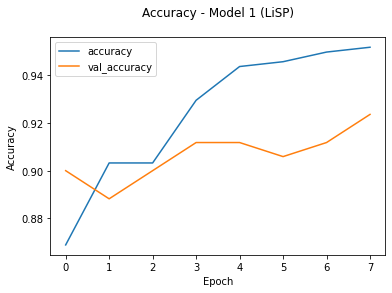

In [85]:
plt.title('Accuracy - Model 1 (LiSP)\n')

plt.plot(hist1.epoch, metrics1['binary_accuracy'], metrics1['val_binary_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
# plt.ylim([0, max(plt.ylim())])/
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

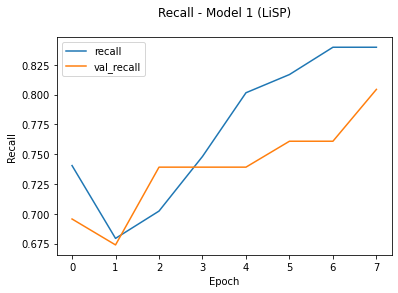

In [86]:
plt.title('Recall - Model 1 (LiSP)\n')


plt.plot(hist1.epoch, metrics1['recall'], metrics1['val_recall'])
plt.legend(['recall', 'val_recall'])
# plt.ylim([0, max(plt.ylim())])/
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.show()

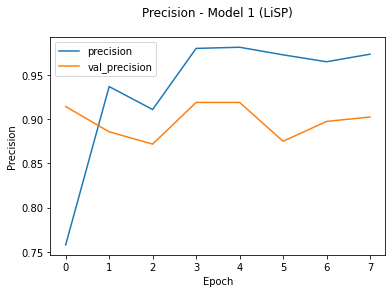

In [87]:
plt.title('Precision - Model 1 (LiSP)\n')


plt.plot(hist1.epoch, metrics1['precision'], metrics1['val_precision'])
plt.legend(['precision', 'val_precision'])
# plt.ylim([0, max(plt.ylim())])/
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.show()

### confusion matrix

In [88]:
Ypred_mod1 = model1.predict(test_m1)

In [89]:
def converting_mod1 (t):
    return 1 if t >= 0.80 else 0 
# values = np.array([convert(xi) for xi in Ypred])

convert_vec_mod1 = np.vectorize(converting_mod1)
newYpred_mod1 = convert_vec_mod1(Ypred_mod1)
newYpred_mod1 = newYpred_mod1.flatten()

In [90]:
Yout_mod1 = np.concatenate([y for x, y in test_m1], axis=0)
print(Yout_mod1[:15])
print(newYpred_mod1[:15])

[1 0 1 1 1 1 1 1 1 1 1 1 1 0 1]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


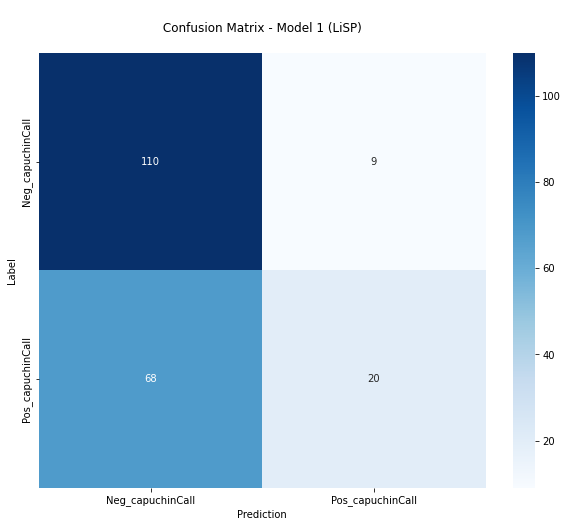

In [91]:
confusion_mtx_mod1 = tf.math.confusion_matrix(Yout_mod1, newYpred_mod1)
plt.figure(figsize=(10, 8))
plt.title('\n Confusion Matrix - Model 1 (LiSP) \n')
sns.heatmap(confusion_mtx_mod1,
            xticklabels=['Neg_capuchinCall', 'Pos_capuchinCall'],
            yticklabels=['Neg_capuchinCall', 'Pos_capuchinCall'],
            annot=True, fmt='g',
            cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [93]:
tnw = confusion_mtx_mod1[0][0].numpy()
fpw = confusion_mtx_mod1[0][1].numpy()
fnw = confusion_mtx_mod1[1][0].numpy()
tpw = confusion_mtx_mod1[1][1].numpy()

print(tnw, fpw, fnw, tpw, '\n')

print("Accuracy:", accuracy_score(Yout_mod1, newYpred_mod1 ))
print("Precision:", precision_score(Yout_mod1, newYpred_mod1 , average="binary"))
print("Recall/Sensitivity:", recall_score(Yout_mod1, newYpred_mod1 , average="binary"))
print("Specificity:", recall_score(np.logical_not(Yout_mod1) , np.logical_not(newYpred_mod1) , average="binary"))
print("F1-score:", f1_score(Yout_mod1, newYpred_mod1 , average="binary") )
print("f-beta:", fbeta_score(Yout_mod1, newYpred_mod1 , average="binary", beta = 0.5))

110 9 68 20 

Accuracy: 0.6280193236714976
Precision: 0.6896551724137931
Recall/Sensitivity: 0.22727272727272727
Specificity: 0.9243697478991597
F1-score: 0.3418803418803419
f-beta: 0.4901960784313725


## Model 2 (LISPAUG) [linear amp spec with data augmnt]

### data_pipeline 2

In [94]:
neglist2 = [*negl1, *negl2]
poslist2 = [*posl1, *posl2, *posl3]


ones2  = onelistmaker(len(poslist2))
zers2  = zerolistmaker(len(neglist2))

len(ones2) , len(zers2) , (len(ones2) + len(zers2))

(638, 668, 1306)

In [95]:
t_ones2 = onelistmaker(len(testl1))
t_zers2 = zerolistmaker(len(testl2))
test_d1 = obt_ds_fromList(testl1, t_ones2) 
test_d2 = obt_ds_fromList(testl2, t_zers2) 

In [96]:
posm2  = obt_ds_fromList(poslist2, ones2)
negm2  = obt_ds_fromList(neglist2, zers2)

print(posm2.element_spec, len(posm2))
print(negm2.element_spec, len(negm2))

(TensorSpec(shape=(129, 171, 1), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None)) 638
(TensorSpec(shape=(129, 171, 1), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None)) 668


In [97]:
data_m2 = negm2.concatenate(posm2)
tdata_m2 = test_d1.concatenate(test_d2)

In [101]:
data_m2 = data_m2.shuffle(buffer_size = 610, seed=seed, reshuffle_each_iteration=False)
print( check_balance(data_m2, 150) , len(data_m2) )

tdata_m2 = tdata_m2.shuffle(buffer_size = 45, seed=seed, reshuffle_each_iteration=False)
print( check_balance(tdata_m2, 50) , len(tdata_m2) )

53.333333333333336
None 1306
80.0
None 63


In [102]:
data_m2 = data_m2.cache()
data_m2 = data_m2.shuffle(buffer_size=610, seed = seed, reshuffle_each_iteration=False)
data_m2 = data_m2.batch(16)
data_m2 = data_m2.prefetch(8)
len(data_m2)

82

### train/test split

In [103]:
# 49 - 12 - 21

train_m2 = data_m2.take(49)
t_data_m2 = data_m2.skip(49).take(33)
tst_m2 = t_data_m2.take(12)
validate_m2 = t_data_m2.skip(12).take(21)

print(len(train_m2), len(tst_m2), len(validate_m2) )

49 12 21


In [104]:
test_labels = np.concatenate([y for x, y in tst_m2], axis=0)
test_spec   = np.concatenate([x for x, y in tst_m2], axis=0)

test_extra = obt_ds_fromList(test_spec, test_labels)

len(test_extra), len(tdata_m2)

(192, 63)

In [105]:
test_m2 = tdata_m2.concatenate(test_extra)
test_m2 = test_m2.batch(16)
test_m2 = test_m2.prefetch(8)
len(test_m2)

16

### model 2 training

In [133]:
model2 = Sequential()

model2.add(layers.Input(shape= (129, 171, 1) ))

model2.add(Conv2D(64, (4,4), activation='relu'))
model2.add(layers.AveragePooling2D(2,2))
# model.add(layers.Dropout(0.3))

model2.add(Conv2D(32, (4,4), activation='relu'))
model2.add(layers.MaxPooling2D(3,3))
# model.add(layers.Dropout(0.3))

model2.add(Flatten())

model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 126, 168, 64)      1088      
_________________________________________________________________
average_pooling2d_11 (Averag (None, 63, 84, 64)        0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 60, 81, 32)        32800     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 20, 27, 32)        0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 17280)             0         
_________________________________________________________________
dense_70 (Dense)             (None, 64)                1105984   
_________________________________________________________________
dense_71 (Dense)             (None, 32)              

In [134]:
model2.compile( optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='BinaryCrossentropy', metrics=['binary_accuracy', 'Recall', 'Precision'])

In [135]:
hist2 = model2.fit(train_m2, epochs=8, validation_data=validate_m2,
       callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, 
                                               patience=4,
                                               restore_best_weights=True
                                              ),
        steps_per_epoch = 49)

Epoch 1/8
49/49 [==============================] - 15s 275ms/step - loss: 0.5845 - binary_accuracy: 0.7883 - recall: 0.8144 - precision: 0.7707 - val_loss: 0.4830 - val_binary_accuracy: 0.7697 - val_recall: 0.6420 - val_precision: 0.8525
Epoch 2/8
49/49 [==============================] - 12s 253ms/step - loss: 0.3883 - binary_accuracy: 0.8495 - recall: 0.8144 - precision: 0.8729 - val_loss: 0.4229 - val_binary_accuracy: 0.8030 - val_recall: 0.7284 - val_precision: 0.8489
Epoch 3/8
49/49 [==============================] - 13s 259ms/step - loss: 0.3190 - binary_accuracy: 0.8635 - recall: 0.8479 - precision: 0.8727 - val_loss: 0.3616 - val_binary_accuracy: 0.8242 - val_recall: 0.7531 - val_precision: 0.8714
Epoch 4/8
49/49 [==============================] - 14s 276ms/step - loss: 0.2805 - binary_accuracy: 0.8852 - recall: 0.8711 - precision: 0.8942 - val_loss: 0.3475 - val_binary_accuracy: 0.8394 - val_recall: 0.8025 - val_precision: 0.8609
Epoch 5/8
49/49 [==============================]

### plotting training performance

In [136]:
metrics2 = hist2.history

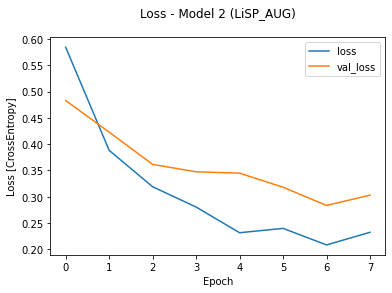

In [137]:
plt.title('Loss - Model 2 (LiSP_AUG)\n')
plt.plot(hist2.epoch, metrics2['loss'], metrics2['val_loss'])
plt.legend(['loss', 'val_loss'])
# plt.ylim([0, max(plt.ylim())])

plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.show()


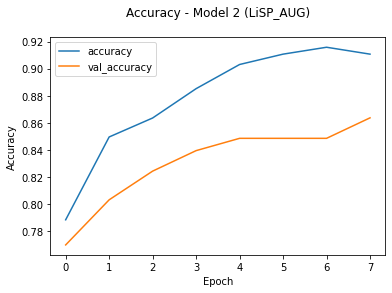

In [138]:
plt.title('Accuracy - Model 2 (LiSP_AUG)\n')
# plt.plot(hist.history['loss'], label="loss")
# plt.plot(hist.history['val_loss'], label="val_loss" )

plt.plot(hist2.epoch, metrics2['binary_accuracy'], metrics2['val_binary_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
# plt.ylim([0, max(plt.ylim())])/
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

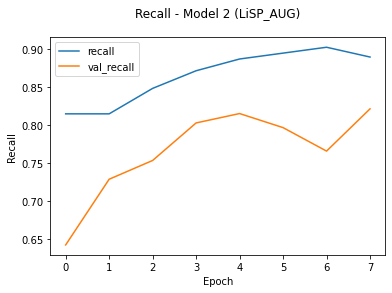

In [139]:
plt.title('Recall - Model 2 (LiSP_AUG)\n')
# plt.plot(hist.history['loss'], label="loss")
# plt.plot(hist.history['val_loss'], label="val_loss" )

plt.plot(hist2.epoch, metrics2['recall'], metrics2['val_recall'])
plt.legend(['recall', 'val_recall'])
# plt.ylim([0, max(plt.ylim())])/
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.show()

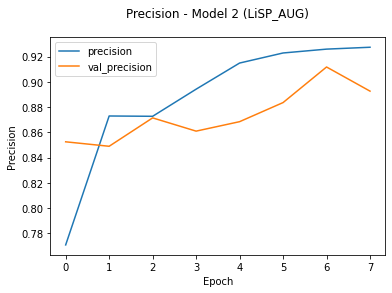

In [140]:
plt.title('Precision - Model 2 (LiSP_AUG)\n')
# plt.plot(hist.history['loss'], label="loss")
# plt.plot(hist.history['val_loss'], label="val_loss" )

plt.plot(hist2.epoch, metrics2['precision'], metrics2['val_precision'])
plt.legend(['precision', 'val_precision'])
# plt.ylim([0, max(plt.ylim())])/
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.show()

### confusion matrix

In [141]:
Ypred_mod2 = model2.predict(test_m2)

In [142]:
def converting_mod2 (t):
    return 1 if t >= 0.80 else 0 


convert_vec_mod2 = np.vectorize(converting_mod2)
newYpred_mod2 = convert_vec_mod2(Ypred_mod2)
newYpred_mod2 = newYpred_mod2.flatten()

In [143]:
Yout_mod2 = np.concatenate([y for x, y in test_m2], axis=0)
print(Yout_mod2[:15])
print(newYpred_mod2[:15])

[1 0 1 1 1 1 1 1 1 1 1 1 1 0 1]
[0 0 0 0 1 1 1 0 1 1 1 0 0 0 1]


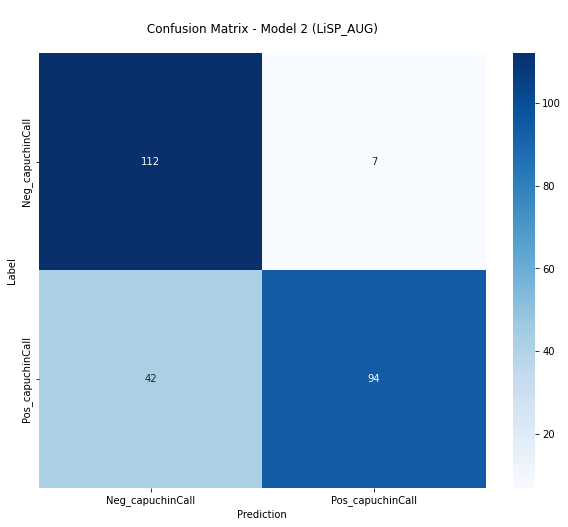

In [144]:
confusion_mtx_mod2 = tf.math.confusion_matrix(Yout_mod2, newYpred_mod2)
plt.figure(figsize=(10, 8))
plt.title('\n Confusion Matrix - Model 2 (LiSP_AUG) \n')

sns.heatmap(confusion_mtx_mod2,
            xticklabels=['Neg_capuchinCall', 'Pos_capuchinCall'],
            yticklabels=['Neg_capuchinCall', 'Pos_capuchinCall'],
            annot=True, fmt='g',
            cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [145]:
tnw = confusion_mtx_mod2[0][0].numpy()
fpw = confusion_mtx_mod2[0][1].numpy()
fnw = confusion_mtx_mod2[1][0].numpy()
tpw = confusion_mtx_mod2[1][1].numpy()

print(tnw, fpw, fnw, tpw, '\n')

print("Accuracy:", accuracy_score(Yout_mod2, newYpred_mod2 ))
print("Precision:", precision_score(Yout_mod2, newYpred_mod2 , average="binary"))
print("Recall/Senstivity:", recall_score(Yout_mod2, newYpred_mod2 , average="binary"))
print("Specificity:", recall_score(np.logical_not(Yout_mod2) , np.logical_not(newYpred_mod2) , average="binary"))
print("F1-score:", f1_score(Yout_mod2, newYpred_mod2 , average="binary") )
print("f-beta:", fbeta_score(Yout_mod2, newYpred_mod2 , average="binary", beta = 0.5))

112 7 42 94 

Accuracy: 0.807843137254902
Precision: 0.9306930693069307
Recall/Senstivity: 0.6911764705882353
Specificity: 0.9411764705882353
F1-score: 0.7932489451476793
f-beta: 0.8703703703703705


## Preprocessing for log amplitude based models

In [203]:
posl1 = [*cap_files]
posl2 = [*aug_files]
posl3 = [*add_cap_files]

negl1 = [*ncap_files]
negl2 = add_ncap_files[:75]
# negl2 = [*add_ncap_files]

testl1 = [*add_test_files]
testl2 = add_ncap_files[-15:]

print(len(posl1), len(posl2), len(posl3))
print(len(negl1), len(negl2))
print(len(testl1), len(testl2))

217 360 61
593 75
48 15


In [227]:
posl1_log = obt_spec_fromList(posl1, cap_dir, val = 'log' )
posl2_log = obt_spec_fromList(posl2, aug_dir, val = 'log')
posl3_log = obt_spec_fromList(posl3, add_cap_dir, val = 'log')

negl1_log = obt_spec_fromList(negl1, non_cap_dir, val = 'log')
negl2_log = obt_spec_fromList(negl2, add_ncap_dir, val = 'log')

testl1_log = obt_spec_fromList(testl1, add_test_dir, val = 'log')
testl2_log = obt_spec_fromList(testl2, add_ncap_dir, val = 'log')

print(len(posl1_log), len(posl2_log), len(posl3_log))
print(len(negl1_log), len(negl2_log))
print(len(testl1_log), len(testl2_log))


217 360 61
593 75
48 15


## Model 3 (LOSP) [log amp spec without data augmnt]

### data_pipeline 3

In [228]:
neglist1 = [*negl1_log]
poslist1 = [*posl1_log]

ones  = onelistmaker(len(poslist1))
zers  = zerolistmaker(len(neglist1))

len(ones) , len(zers) , (len(ones) + len(zers))

(217, 593, 810)

In [231]:
t_ones = onelistmaker(len(testl1_log))
t_zers = zerolistmaker(len(testl2_log))
test_d1 = obt_ds_fromList(testl1_log, t_ones) 
test_d2 = obt_ds_fromList(testl2_log, t_zers) 

In [230]:
pos1  = obt_ds_fromList(poslist1, ones)
neg1  = obt_ds_fromList(neglist1, zers)

print(pos1.element_spec, len(pos1))
print(neg1.element_spec, len(neg1))

(TensorSpec(shape=(129, 171, 1), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None)) 217
(TensorSpec(shape=(129, 171, 1), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None)) 593


In [232]:
data_m3 = neg1.concatenate(pos1)
tdata_m3 = test_d1.concatenate(test_d2)

In [236]:
data_m3 = data_m3.shuffle(buffer_size = 610, seed=seed, reshuffle_each_iteration=False)
print( check_balance(data_m3, 150) , len(data_m3) )

tdata_m3 = tdata_m3.shuffle(buffer_size = 45, seed=seed, reshuffle_each_iteration=False)
print( check_balance(tdata_m3, 50) , len(tdata_m3) )

28.666666666666668
None 810
80.0
None 63


In [237]:
data_m3 = data_m3.cache()
data_m3 = data_m3.shuffle(buffer_size=610, seed = seed, reshuffle_each_iteration=False)
data_m3 = data_m3.batch(16)
data_m3 = data_m3.prefetch(8)
len(data_m3)

51

### train/test split

In [238]:
# 31 - 9 - 11

train_m3 = data_m3.take(31)
t_data_m3 = data_m3.skip(31).take(20)
tst_m3 = t_data_m3.take(9)
validate_m3 = t_data_m3.skip(9).take(11)

print(len(train_m3), len(tst_m3), len(validate_m3) )

31 9 11


In [239]:
test_labels = np.concatenate([y for x, y in tst_m3], axis=0)
test_spec   = np.concatenate([x for x, y in tst_m3], axis=0)

test_extra = obt_ds_fromList(test_spec, test_labels)

len(test_extra), len(tdata_m3)

(144, 63)

In [240]:
test_m3 = tdata_m3.concatenate(test_extra)

test_m3 = test_m3.batch(16)
test_m3 = test_m3.prefetch(8)
len(test_m3)

13

### model 3 training

In [242]:
model3 = Sequential()

model3.add(layers.Input(shape= (129, 171, 1) ))

model3.add(Conv2D(64, (4,4), activation='relu'))
model3.add(layers.AveragePooling2D(2,2))
# model.add(layers.Dropout(0.3))

model3.add(Conv2D(32, (4,4), activation='relu'))
model3.add(layers.MaxPooling2D(3,3))
# model.add(layers.Dropout(0.3))

model3.add(Flatten())

model3.add(Dense(64, activation='relu'))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 126, 168, 64)      1088      
_________________________________________________________________
average_pooling2d_17 (Averag (None, 63, 84, 64)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 60, 81, 32)        32800     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 20, 27, 32)        0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 17280)             0         
_________________________________________________________________
dense_85 (Dense)             (None, 64)                1105984   
_________________________________________________________________
dense_86 (Dense)             (None, 32)              

In [243]:
model3.compile( optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='BinaryCrossentropy', metrics=['binary_accuracy', 'Recall', 'Precision'])


In [244]:
hist3 = model3.fit(train_m3, epochs=8, validation_data=validate_m3,
       callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, 
                                               patience=4,
                                               restore_best_weights=True
                                              ),
        steps_per_epoch = 31)

Epoch 1/8
31/31 [==============================] - 10s 278ms/step - loss: 0.7367 - binary_accuracy: 0.7722 - recall: 0.4733 - precision: 0.5849 - val_loss: 0.2250 - val_binary_accuracy: 0.9000 - val_recall: 0.7391 - val_precision: 0.8718
Epoch 2/8
31/31 [==============================] - 9s 290ms/step - loss: 0.1686 - binary_accuracy: 0.9415 - recall: 0.8626 - precision: 0.9113 - val_loss: 0.1682 - val_binary_accuracy: 0.9235 - val_recall: 0.7391 - val_precision: 0.9714
Epoch 3/8
31/31 [==============================] - 8s 266ms/step - loss: 0.1077 - binary_accuracy: 0.9617 - recall: 0.9237 - precision: 0.9308 - val_loss: 0.1789 - val_binary_accuracy: 0.9176 - val_recall: 0.6957 - val_precision: 1.0000
Epoch 4/8
31/31 [==============================] - 8s 261ms/step - loss: 0.0887 - binary_accuracy: 0.9718 - recall: 0.9313 - precision: 0.9606 - val_loss: 0.1734 - val_binary_accuracy: 0.9176 - val_recall: 0.6957 - val_precision: 1.0000
Epoch 5/8
31/31 [==============================] - 

### plotting training performance

In [245]:
metrics3 = hist3.history

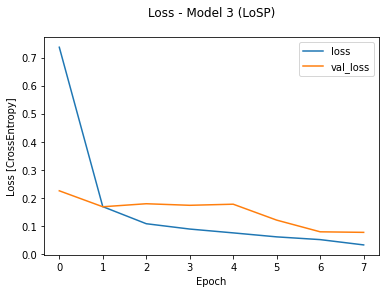

In [246]:
plt.title('Loss - Model 3 (LoSP)\n')

plt.plot(hist3.epoch, metrics3['loss'], metrics3['val_loss'])
plt.legend(['loss', 'val_loss'])
# plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.show()

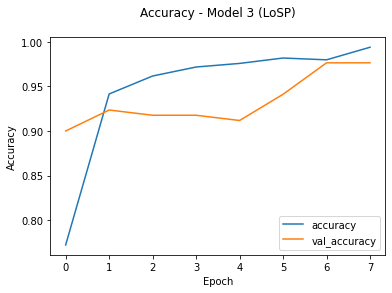

In [247]:
plt.title('Accuracy - Model 3 (LoSP)\n')

plt.plot(hist3.epoch, metrics3['binary_accuracy'], metrics3['val_binary_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
# plt.ylim([0, max(plt.ylim())])/
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


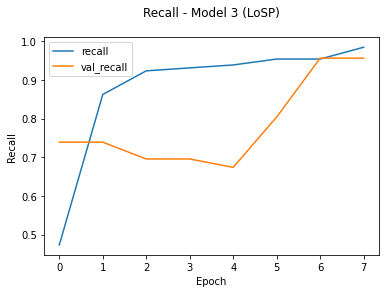

In [248]:
plt.title('Recall - Model 3 (LoSP)\n')

plt.plot(hist3.epoch, metrics3['recall'], metrics3['val_recall'])
plt.legend(['recall', 'val_recall'])
# plt.ylim([0, max(plt.ylim())])/
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.show()

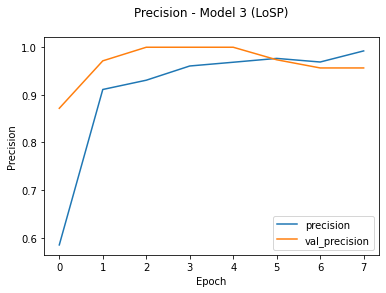

In [249]:
plt.title('Precision - Model 3 (LoSP)\n')

plt.plot(hist3.epoch, metrics3['precision'], metrics3['val_precision'])
plt.legend(['precision', 'val_precision'])
# plt.ylim([0, max(plt.ylim())])/
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.show()

### cofusion matrix 

In [250]:
Ypred_mod3 = model3.predict(test_m3)


In [251]:
def converting_mod3 (t):
    return 1 if t >= 0.80 else 0 


convert_vec_mod3 = np.vectorize(converting_mod3)
newYpred_mod3 = convert_vec_mod3(Ypred_mod3)
newYpred_mod3 = newYpred_mod3.flatten()

In [252]:
Yout_mod3 = np.concatenate([y for x, y in test_m3], axis=0)
print(Yout_mod3[:15])
print(newYpred_mod3[:15])


[1 0 1 1 1 1 1 1 1 1 1 1 1 0 1]
[0 0 1 0 1 0 1 1 1 1 0 1 0 0 0]


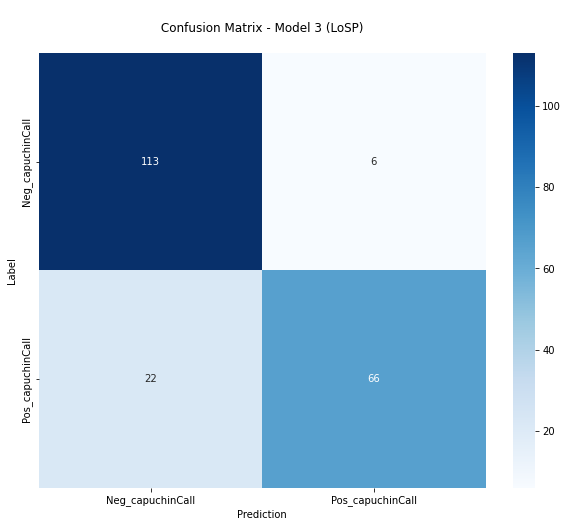

In [253]:
confusion_mtx_mod3 = tf.math.confusion_matrix(Yout_mod3, newYpred_mod3)
plt.figure(figsize=(10, 8))
plt.title('\n Confusion Matrix - Model 3 (LoSP) \n')
sns.heatmap(confusion_mtx_mod3,
            xticklabels=['Neg_capuchinCall', 'Pos_capuchinCall'],
            yticklabels=['Neg_capuchinCall', 'Pos_capuchinCall'],
            annot=True, fmt='g',
            cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [254]:
tnw = confusion_mtx_mod3[0][0].numpy()
fpw = confusion_mtx_mod3[0][1].numpy()
fnw = confusion_mtx_mod3[1][0].numpy()
tpw = confusion_mtx_mod3[1][1].numpy()

print(tnw, fpw, fnw, tpw, '\n')

print("Accuracy:", accuracy_score(Yout_mod3, newYpred_mod3 ))
print("Precision:", precision_score(Yout_mod3, newYpred_mod3 , average="binary"))
print("Recall/Sensitivity:", recall_score(Yout_mod3, newYpred_mod3 , average="binary"))
print("Specificity:", recall_score(np.logical_not(Yout_mod3) , np.logical_not(newYpred_mod3) , average="binary"))
print("F1-score:", f1_score(Yout_mod3, newYpred_mod3 , average="binary") )
print("F-beta:", fbeta_score(Yout_mod3, newYpred_mod3 , average="binary", beta = 0.5))

113 6 22 66 

Accuracy: 0.8647342995169082
Precision: 0.9166666666666666
Recall/Sensitivity: 0.75
Specificity: 0.9495798319327731
F1-score: 0.8250000000000001
F-beta: 0.8776595744680852


## Model 4 (LOSPAUG) [log amp spec with data augmnt]

### data_pipeline 4

In [255]:
neglist1 = [*negl1_log, *negl2_log]
poslist1 = [*posl1_log, *posl2_log, *posl3_log]

ones  = onelistmaker(len(poslist1))
zers  = zerolistmaker(len(neglist1))

len(ones) , len(zers) , (len(ones) + len(zers))


(638, 668, 1306)

In [256]:
t_ones = onelistmaker(len(testl1_log))
t_zers = zerolistmaker(len(testl2_log))
test_d1 = obt_ds_fromList(testl1_log, t_ones) 
test_d2 = obt_ds_fromList(testl2_log, t_zers) 

In [257]:
pos1  = obt_ds_fromList(poslist1, ones)
neg1  = obt_ds_fromList(neglist1, zers)

print(pos1.element_spec, len(pos1))
print(neg1.element_spec, len(neg1))

(TensorSpec(shape=(129, 171, 1), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None)) 638
(TensorSpec(shape=(129, 171, 1), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None)) 668


In [258]:
print(test_d1.element_spec, len(pos1))
print(test_d2.element_spec, len(neg1))

(TensorSpec(shape=(129, 171, 1), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None)) 638
(TensorSpec(shape=(129, 171, 1), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None)) 668


In [259]:
data_m4 = neg1.concatenate(pos1)
tdata_m4 = test_d1.concatenate(test_d2)

In [260]:
print(tdata_m4.element_spec)

(TensorSpec(shape=(129, 171, 1), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))


In [264]:
data_m4 = data_m4.shuffle(buffer_size = 610, seed=seed, reshuffle_each_iteration=False)
print( check_balance(data_m4, 150) , len(data_m4) )

tdata_m4 = tdata_m4.shuffle(buffer_size = 45, seed=seed, reshuffle_each_iteration=False)
print( check_balance(tdata_m4, 50) , len(tdata_m4) )

53.333333333333336
None 1306
80.0
None 63


In [265]:
data_m4 = data_m4.cache()
data_m4 = data_m4.shuffle(buffer_size=610, seed = seed, reshuffle_each_iteration=False)
data_m4 = data_m4.batch(16)
data_m4 = data_m4.prefetch(8)
len(data_m4)

82

### train/test split

In [266]:
# 49 - 11 - 22

train_m4 = data_m4.take(49)
temp_data_m4 = data_m4.skip(49).take(33)
tst_m4 = temp_data_m4.take(11)
validate_m4 = temp_data_m4.skip(11).take(22)

print(len(train_m4), len(tst_m4), len(validate_m4) )


49 11 22


In [267]:
test_labels = np.concatenate([y for x, y in tst_m4], axis=0)
test_spec   = np.concatenate([x for x, y in tst_m4], axis=0)

test_extra = obt_ds_fromList(test_spec, test_labels)

len(test_extra), len(tdata_m4)

(176, 63)

In [268]:
test_m4 = tdata_m4.concatenate(test_extra)

test_m4 = test_m4.batch(16)
test_m4 = test_m4.prefetch(8)
len(test_m4)

15

### model 4 training

In [308]:
model4 = Sequential()

model4.add(layers.Input(shape= (129, 171, 1) ))

model4.add(Conv2D(64, (4,4), activation='relu'))
model4.add(layers.AveragePooling2D(2,2))
# model.add(layers.Dropout(0.3))

model4.add(Conv2D(32, (4,4), activation='relu'))
model4.add(layers.MaxPooling2D(3,3))
# model.add(layers.Dropout(0.3))

model4.add(Flatten())

model4.add(Dense(64, activation='relu'))
model4.add(Dense(32, activation='relu'))

model4.add(Dense(1, activation='sigmoid'))

model4.summary()


Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 126, 168, 64)      1088      
_________________________________________________________________
average_pooling2d_21 (Averag (None, 63, 84, 64)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 60, 81, 32)        32800     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 20, 27, 32)        0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 17280)             0         
_________________________________________________________________
dense_97 (Dense)             (None, 64)                1105984   
_________________________________________________________________
dense_98 (Dense)             (None, 32)              

In [309]:
model4.compile( optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), loss='BinaryCrossentropy', metrics=['binary_accuracy', 'Recall', 'Precision'])


In [310]:
hist4 = model4.fit(train_m4, epochs=12, validation_data=validate_m4,
       callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, 
                                               patience=4,
                                               restore_best_weights=True
                                              ),
        steps_per_epoch = 49)

Epoch 1/12
49/49 [==============================] - 14s 258ms/step - loss: 0.5035 - binary_accuracy: 0.7768 - recall: 0.7706 - precision: 0.7766 - val_loss: 0.3080 - val_binary_accuracy: 0.8613 - val_recall: 0.9760 - val_precision: 0.7874
Epoch 2/12
49/49 [==============================] - 14s 286ms/step - loss: 0.2858 - binary_accuracy: 0.8776 - recall: 0.8918 - precision: 0.8650 - val_loss: 0.2417 - val_binary_accuracy: 0.8988 - val_recall: 0.8443 - val_precision: 0.9400
Epoch 3/12
49/49 [==============================] - 13s 256ms/step - loss: 0.1834 - binary_accuracy: 0.9298 - recall: 0.9356 - precision: 0.9237 - val_loss: 0.1996 - val_binary_accuracy: 0.9249 - val_recall: 0.8862 - val_precision: 0.9548
Epoch 4/12
49/49 [==============================] - 13s 258ms/step - loss: 0.1279 - binary_accuracy: 0.9592 - recall: 0.9716 - precision: 0.9472 - val_loss: 0.1807 - val_binary_accuracy: 0.9364 - val_recall: 0.9102 - val_precision: 0.9560
Epoch 5/12
49/49 [==========================

### plotting training performance

In [311]:
metrics4 = hist4.history

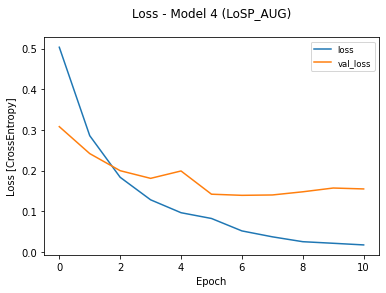

In [312]:
plt.title('Loss - Model 4 (LoSP_AUG)\n')

plt.plot(hist4.epoch, metrics4['loss'], metrics4['val_loss'])
plt.legend(['loss', 'val_loss'])
# plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')
plt.show()

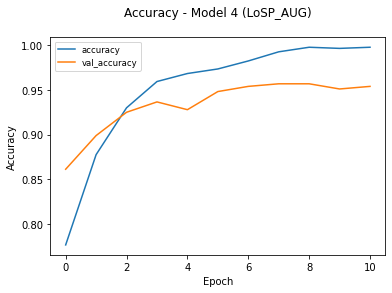

In [313]:
plt.title('Accuracy - Model 4 (LoSP_AUG)\n')

plt.plot(hist4.epoch, metrics4['binary_accuracy'], metrics4['val_binary_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
# plt.ylim([0, max(plt.ylim())])/
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

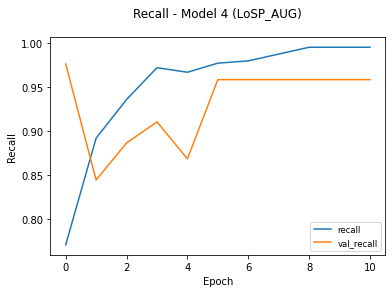

In [314]:
plt.title('Recall - Model 4 (LoSP_AUG)\n')

plt.plot(hist4.epoch, metrics4['recall'], metrics4['val_recall'])
plt.legend(['recall', 'val_recall'])
# plt.ylim([0, max(plt.ylim())])/
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.show()


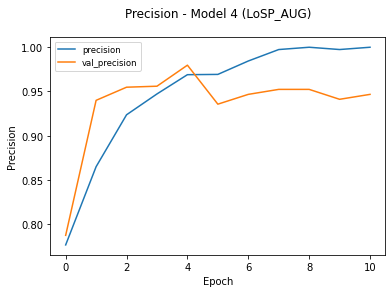

In [315]:
plt.title('Precision - Model 4 (LoSP_AUG)\n')

plt.plot(hist4.epoch, metrics4['precision'], metrics4['val_precision'])
plt.legend(['precision', 'val_precision'])
# plt.ylim([0, max(plt.ylim())])/
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.show()

### confusion matrix

In [316]:
Ypred_mod4 = model4.predict(test_m4)

In [317]:
def converting_mod4 (t):
    return 1 if t >= 0.80 else 0 


convert_vec_mod4 = np.vectorize(converting_mod4)
newYpred_mod4 = convert_vec_mod4(Ypred_mod4)
newYpred_mod4 = newYpred_mod4.flatten()


In [318]:
Yout_mod4 = np.concatenate([y for x, y in test_m4], axis=0)
print(Yout_mod4[:15])
print(newYpred_mod4[:15])

[1 0 1 1 1 1 1 1 1 1 1 1 1 0 1]
[1 0 0 1 1 1 1 0 1 1 1 1 0 0 0]


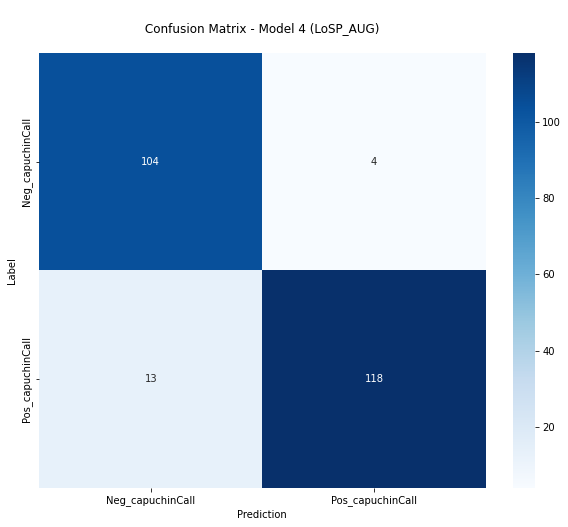

In [319]:
confusion_mtx_mod4 = tf.math.confusion_matrix(Yout_mod4, newYpred_mod4)
plt.figure(figsize=(10, 8))
plt.title('\n Confusion Matrix - Model 4 (LoSP_AUG) \n')

sns.heatmap(confusion_mtx_mod4,
            xticklabels=['Neg_capuchinCall', 'Pos_capuchinCall'],
            yticklabels=['Neg_capuchinCall', 'Pos_capuchinCall'],
            annot=True, fmt='g',
            cmap=plt.cm.Blues)
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [320]:
tnw = confusion_mtx_mod4[0][0].numpy()
fpw = confusion_mtx_mod4[0][1].numpy()
fnw = confusion_mtx_mod4[1][0].numpy()
tpw = confusion_mtx_mod4[1][1].numpy()

print(tnw, fpw, fnw, tpw, '\n')

print("Accuracy:", accuracy_score(Yout_mod4, newYpred_mod4 ))
print("Precision:", precision_score(Yout_mod4, newYpred_mod4 , average="binary"))
print("Recall/Sensitivity:", recall_score(Yout_mod4, newYpred_mod4 , average="binary"))
print("Specificity:", recall_score(np.logical_not(Yout_mod4) , np.logical_not(newYpred_mod4) , average="binary"))

# print("Specificity:", recall_score(Yout_mod4, newYpred_mod4, pos_label=0, average="binary") )

print("F1-score:", f1_score(Yout_mod4, newYpred_mod4 , average="binary") )
print("f-beta:", fbeta_score(Yout_mod4, newYpred_mod4 , average="binary", beta = 0.5))

104 4 13 118 

Accuracy: 0.9288702928870293
Precision: 0.9672131147540983
Recall/Sensitivity: 0.9007633587786259
Specificity: 0.9629629629629629
F1-score: 0.9328063241106719
f-beta: 0.9531502423263327


## Comparing All 4 models 

### ROC-AUC curve

In [304]:
#model1
fpr1, tpr1, thresholds1 = metrics.roc_curve(Yout_mod1, newYpred_mod1)
roc_auc1 = metrics.auc(fpr1, tpr1)

#model2
fpr2, tpr2, thresholds2 = metrics.roc_curve(Yout_mod2, newYpred_mod2)
roc_auc2 = metrics.auc(fpr2, tpr2)

#model3
fpr3, tpr3, thresholds3 = metrics.roc_curve(Yout_mod3, newYpred_mod3)
roc_auc3 = metrics.auc(fpr3, tpr3)

#model4
fpr4, tpr4, thresholds4 = metrics.roc_curve(Yout_mod4, newYpred_mod4)
roc_auc4 = metrics.auc(fpr4, tpr4)

In [305]:
auc_mod1 = auc(fpr1, tpr1)         #Lisp
auc_mod2 = auc(fpr2, tpr2)         #Lisp_AUG
auc_mod3 = auc(fpr3, tpr3)         #LoSP
auc_mod4 = auc(fpr4, tpr4)         #LoSP_AUG

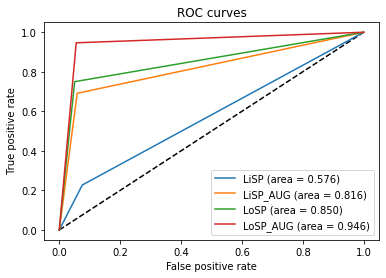

In [306]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr1, tpr1, label='LiSP (area = {:.3f})'.format(auc_mod1))
plt.plot(fpr2, tpr2, label='LiSP_AUG (area = {:.3f})'.format(auc_mod2))
plt.plot(fpr3, tpr3, label='LoSP (area = {:.3f})'.format(auc_mod3))
plt.plot(fpr4, tpr4, label='LoSP_AUG (area = {:.3f})'.format(auc_mod4))

plt.xlabel('False positive rate')
plt.ylabel(' True positive rate')
plt.title('ROC curves')
plt.legend(loc='best')
plt.show()

### Precision-Recall Curve 

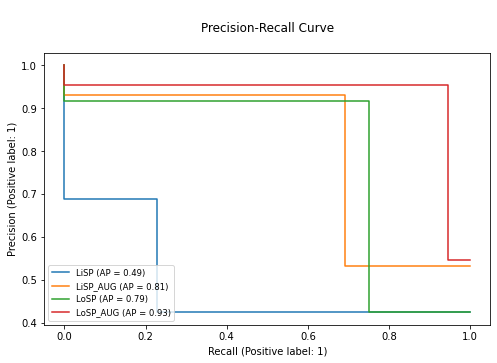

In [307]:
plt.rc('legend', fontsize=8.5)    # legend fontsize
fig, ax = plt.subplots(figsize=(8, 5))
plt.title('\nPrecision-Recall Curve\n')
PrecisionRecallDisplay.from_predictions(Yout_mod1, newYpred_mod1, ax=ax, name='LiSP')
PrecisionRecallDisplay.from_predictions(Yout_mod2, newYpred_mod2, ax=ax, name='LiSP_AUG')

PrecisionRecallDisplay.from_predictions(Yout_mod3, newYpred_mod3, ax=ax, name='LoSP')
PrecisionRecallDisplay.from_predictions(Yout_mod4, newYpred_mod4, ax=ax, name='LoSP_AUG')
plt.show()